In [1]:
import cv2 as cv
import numpy as np
import os
import time
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
vid_path = os.environ['USERPROFILE'] + '/Videos/jellyfish-120-mbps-4k-uhd-h264.mkv'

In [3]:
cap = cv.VideoCapture(vid_path)

In [4]:
ret, frame = cap.read()

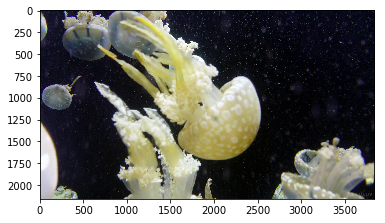

In [5]:
plt.imshow(cv.cvtColor(frame,cv.COLOR_BGR2RGB));

In [6]:
mask = np.ones(frame.shape,dtype='uint8')*255
frame.shape,mask.shape

((2160, 3840, 3), (2160, 3840, 3))

In [7]:
n = 1000
mask[:n,:n] = 0

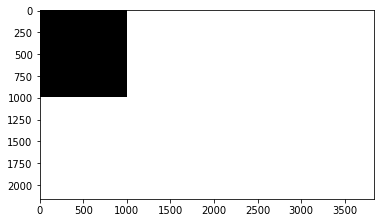

In [8]:
plt.imshow(mask);

### Host

In [9]:
img_masked = cv.bitwise_and(frame,mask)

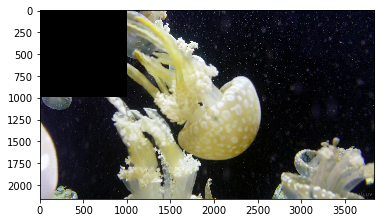

In [10]:
plt.imshow(cv.cvtColor(img_masked,cv.COLOR_BGR2RGB));

In [11]:
%timeit img_masked = cv.bitwise_and(frame,mask)

11 ms ± 172 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
%timeit cv.bitwise_and(frame,mask,img_masked)

3.19 ms ± 32.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Device

In [13]:
help(cv.cuda.bitwise_and)

Help on built-in function bitwise_and:

bitwise_and(...)
    bitwise_and(src1, src2[, dst[, mask[, stream]]]) -> dst
    .   @brief Performs a per-element bitwise conjunction of two matrices (or of matrix and scalar).
    .   
    .   @param src1 First source matrix or scalar.
    .   @param src2 Second source matrix or scalar.
    .   @param dst Destination matrix that has the same size and type as the input array(s).
    .   @param mask Optional operation mask, 8-bit single channel array, that specifies elements of the
    .   destination array to be changed. The mask can be used only with single channel images.
    .   @param stream Stream for the asynchronous version.



In [14]:
frame_device = cv.cuda_GpuMat(frame)
mask_device = cv.cuda_GpuMat(mask)
frame_device.size(),frame_device.channels(),frame_device.type()

((3840, 2160), 3, 16)

In [15]:
img_masked_device = cv.cuda.bitwise_and(frame_device,mask_device)

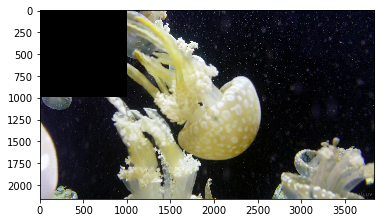

In [16]:
plt.imshow(cv.cvtColor(img_masked_device.download(),cv.COLOR_BGR2RGB));

In [17]:
%timeit img_masked_device = cv.cuda.bitwise_and(frame_device,mask_device)

1.67 ms ± 10.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [18]:
%timeit cv.cuda.bitwise_and(frame_device,mask_device,img_masked_device)

257 µs ± 12.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Compare with perfomance of multiply

In [19]:
mask_mult = np.ones(frame.shape,dtype='uint8')
n = 1000
mask_mult[:n,:n] = 0
mask_mult_device = cv.cuda_GpuMat(mask_mult)

In [20]:
img_masked_device = cv.cuda.multiply(frame_device,mask_mult_device)

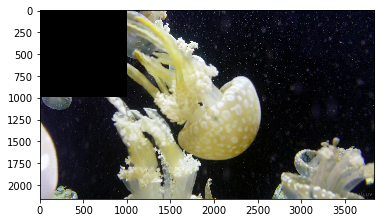

In [21]:
plt.imshow(cv.cvtColor(img_masked_device.download(),cv.COLOR_BGR2RGB));

In [22]:
%timeit img_masked_device = cv.cuda.multiply(frame_device,mask_mult_device)

1.5 ms ± 15.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [23]:
%timeit cv.cuda.multiply(frame_device,mask_mult_device,img_masked_device)

281 µs ± 11.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Compare merge performance

### Host

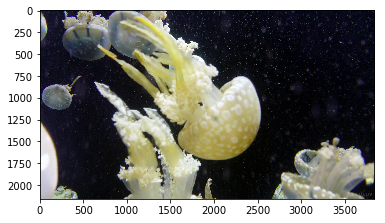

In [24]:
[b,g,r] = cv.split(frame)
dst = cv.merge([b,g,r])
plt.imshow(cv.cvtColor(dst,cv.COLOR_BGR2RGB));

In [25]:
%timeit dst = cv.merge([r,g,b])

9.34 ms ± 85.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
%timeit cv.merge([r,g,b],dst)

1.48 ms ± 36.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Device

In [27]:
r_device = cv.cuda_GpuMat(frame_device.size(),cv.CV_8UC1) 
g_device = cv.cuda_GpuMat(frame_device.size(),cv.CV_8UC1) 
b_device = cv.cuda_GpuMat(frame_device.size(),cv.CV_8UC1)
dst_device = cv.cuda_GpuMat(frame_device.size(),cv.CV_8UC3)
cv.cuda.split(frame_device,[b_device,g_device,r_device])

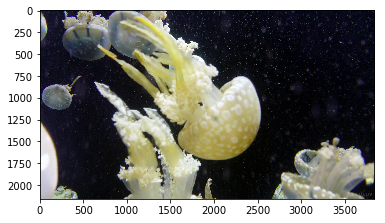

In [28]:
cv.cuda.merge([b_device,g_device,r_device],dst_device);
plt.imshow(cv.cvtColor(dst_device.download(),cv.COLOR_BGR2RGB));

In [29]:
%timeit cv.cuda.merge([b_device,g_device,r_device])

13 ms ± 146 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
%timeit cv.cuda.merge([b_device,g_device,r_device],dst_device)

219 µs ± 11.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
